In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import APSIMGraphHelpers as AGH
import GraphHelpers as GH
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.dates as mdates
import MathsUtilities as MUte
import shlex # package to construct the git command to subprocess format
import subprocess 
import ProcessWheatFiles as pwf
import xmltodict, json
import sqlite3
import scipy.optimize 
from skopt import gp_minimize
from skopt.callbacks import CheckpointSaver
from skopt import load
from skopt.plots import plot_convergence
import re

from py_expression_eval import Parser
parser = Parser()

import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
%matplotlib inline

pd.set_option('display.max_rows', 100)

In [2]:
Path = 'C:\GitHubRepos\ApsimX\Prototypes\SimplifiedOrganArbitrator\FodderBeetOptimise'

BlankManager = {'$type': 'Models.Manager, Models',
            'Code': '',
            'Parameters': None,
            'Name': 'SetCropParameters',
            'IncludeInDocumentation': False,
            'Enabled': True,
            'ReadOnly': False}

SetCropParams = {
          "$type": "Models.Manager, Models",
          "Code": "using Models.Core;\r\nusing System;\r\nnamespace Models\r\n{\r\n\t[Serializable]\r\n    public class Script : Model\r\n    {\r\n        [Link] Zone zone;\r\n        [EventSubscribe(\"PlantSowing\")]\r\n        private void OnPlantSowing(object sender, EventArgs e)\r\n        {\r\n            object PpFac12 = 0.8;\r\n            zone.Set(\"Wheat.Phenology.CAMP.PpResponse.XYPairs.Y[3]\", PpFac12);  \r\n            object DeVernFac = -.3;\r\n            zone.Set(\"Wheat.Phenology.CAMP.DailyColdVrn1.Response.DeVernalisationRate.FixedValue\", DeVernFac);  \r\n        }\r\n    }\r\n}\r\n                \r\n",
          "Parameters": [],
          "Name": "SetCropParameters",
          "IncludeInDocumentation": False,
          "Enabled": True,
          "ReadOnly": False}

def AppendModeltoModelofTypeAndDeleteOldIfPresent(Parent,TypeToAppendTo,ModelToAppend):
    try:
        for child in Parent['Children']:
            if child['$type'] == TypeToAppendTo:
                pos = 0
                for g in child['Children']:
                    if g['Name'] == ModelToAppend['Name']:
                        del child['Children'][pos]
                        #print('Model ' + ModelToAppend['Name'] + ' found and deleted')
                    pos+=1
                child['Children'].append(ModelToAppend)
            else:
                Parent = AppendModeltoModelofTypeAndDeleteOldIfPresent(child,TypeToAppendTo,ModelToAppend)
        return Parent
    except:
        return Parent
    
def AppendModeltoModelofType(Parent,TypeToAppendTo,ModelToAppend):
    try:
        for child in Parent['Children']:
            if child['$type'] == TypeToAppendTo:
                child['Children'].append(ModelToAppend)
            else:
                Parent = AppendModeltoModelofType(child,TypeToAppendTo,ModelToAppend)
        return Parent
    except:
        return Parent
    
def findNextChild(Parent,ChildName):
    if len(Parent['Children']) >0:
        for child in range(len(Parent['Children'])):
            if Parent['Children'][child]['Name'] == ChildName:
                return Parent['Children'][child]
    else:
        return Parent[ChildName]

def findModel(Parent,PathElements):
    for pe in PathElements:
        Parent = findNextChild(Parent,pe)
    return Parent   

def replaceModel(Parent,modelPath,New):
    PathElements = modelPath.split('.')
    if PathElements[-1][-1] != "]":
        findModel(Parent,PathElements[:-1])[PathElements[-1]] = New
    else:
        findModel(Parent,PathElements[:-1])[PathElements[-1][0]][int(PathElements[-1][-2])-1] = New

def StopReporting(WheatApsimx,modelPath):
    PathElements = modelPath.split('.')
    report = findModel(WheatApsimx,PathElements)
    report["EventNames"] = []

def removeModel(Parent,modelPath):
    PathElements = modelPath.split('.')
    Parent = findModel(Parent,PathElements[:-1])
    pos = 0
    found = False
    for c in Parent['Children']:
        if c['Name'] == PathElements[-1]:
            del Parent['Children'][pos]
            found = True
            break
        pos += 1
    if found == False:
        print('Failed to find ' + PathElements[-1] + ' to delete')

def ApplyParamReplacementSet(paramValues,paramNames,filePath):
    with open(filePath,'r',encoding="utf8") as ApsimxJSON:
        Apsimx = json.load(ApsimxJSON)
        ApsimxJSON.close()

    ## Add crop coefficient overwrite into replacements
    for p in range(len(paramValues)):
        replaceModel(Apsimx,
                     paramNames[p],
                     paramValues[p])

    with open(filePath,'w') as ApsimxJSON:
        json.dump(Apsimx,ApsimxJSON,indent=2)
        
def makeLongString(SimulationSet):
    longString =  '/SimulationNameRegexPattern:"'
    longString =  longString + '(' + SimulationSet[0]  + ')|' # Add first on on twice as apsim doesn't run the first in the list
    for sim in SimulationSet[:]:
        longString = longString + '(' + sim + ')|'
    longString = longString + '(' + SimulationSet[-1] + ')'#|' ## Add Last on on twice as apsim doesnt run the last in the list
    #longString = longString + '(' + SimulationSet[-1] + ')"'
    return longString

def CalcScaledValue(Value,RMax,RMin):
    return (Value - RMin)/(RMax-RMin)

In [3]:
def Preparefile():
    !del C:\GitHubRepos\ApsimX\Prototypes\SimplifiedOrganArbitrator\FodderBeetOptimise.db

    
def runModelItter(paramSet,OptimisationVariables,SimulationSet,paramsTried):        
    paramAddresses = [ParamData.loc[x,'Address'] for x in paramSet.index]
    absoluteParamValues = deriveIfRelativeTo(paramSet)
    ApplyParamReplacementSet(absoluteParamValues,paramAddresses,Path+'.apsimx') # write parameter set into model
    start = dt.datetime.now()
    simSet = makeLongString(SimulationSet) # make command string with simulations to run
    subprocess.run(['C:/GitHubRepos/ApsimX/bin/Debug/netcoreapp3.1/Models.exe',
                    Path+'.apsimx',
                   simSet], stdout=subprocess.PIPE, stderr=subprocess.STDOUT, check=True)  # Run simulations
    endrun = dt.datetime.now()
    runtime = (endrun-start).seconds
    con = sqlite3.connect(r'C:\GitHubRepos\ApsimX\Prototypes\SimplifiedOrganArbitrator\FodderBeetOptimise.db')
    try:
        ObsPred = pd.read_sql("Select * from PredictedObserved",con)  # read observed and predicted data
        con.close()
    except:
        con.close()
        print("Simulations must not have run as no data in PredictedObserved")
    DataSize = pd.DataFrame(VariableWeights.loc[OptimisationVariables,step])  #data frame with weighting for each variable
    DataSize.loc[:,'size'] =  [ObsPred.loc[:,"Observed."+v].dropna().size for v in OptimisationVariables] # add the data size for each variable
    DataSize.loc[:,'sizeBalance'] = [round(DataSize.loc[:,'size'].max()/DataSize.loc[v,'size']) for v in DataSize.index]  # add size wieghting for each variable
    DataSize.loc[:,'weighting'] = DataSize.loc[:,step] * DataSize.loc[:,'sizeBalance'] # Calculate overall weighting for each variable
    ScObsPre = pd.DataFrame(columns = ['ScObs','ScPred','Var','SimulationID'])  # make blank dataframe to put scalled obs pred values in
    indloc = 0
    for var in OptimisationVariables:
        weighting = DataSize.loc[var,'weighting']
        DataPairs = ObsPred.reindex(['Observed.'+var,'Predicted.'+var,'SimulationID'],axis=1).dropna() # slice out data we need for doing stats
        for c in DataPairs.columns:
            DataPairs.loc[:,c] = pd.to_numeric(DataPairs.loc[:,c])  # ensure all values are numeric, not objects
        VarMax = max(DataPairs.loc[:,'Observed.'+var].max(),DataPairs.loc[:,'Predicted.'+var].max())  # maximum for variable
        VarMin = min(DataPairs.loc[:,'Observed.'+var].min(),DataPairs.loc[:,'Predicted.'+var].min())  # minimum for variable
        DataPairs = pd.DataFrame(index = np.repeat(DataPairs.index,weighting),
                                  data = np.repeat(DataPairs.values,weighting ,axis=0),columns = DataPairs.columns)  # Replicate data to give required weighting
        DataPairs.reset_index(inplace=True) # make index unique
        for x in DataPairs.index:
            ScObsPre.loc[indloc,'ScObs'] = CalcScaledValue(DataPairs.loc[x,'Observed.'+var],VarMax,VarMin)  # Scale observed values between VarMin (0) and VarMax (1)
            ScObsPre.loc[indloc,'ScPred'] = CalcScaledValue(DataPairs.loc[x,'Predicted.'+var],VarMax,VarMin) # Scale predicted values between VarMin (0) and VarMax (1)
            ScObsPre.loc[indloc,'Var'] = var  # assign variable name for indexing
            ScObsPre.loc[indloc,'SimulationID'] = DataPairs.loc[x,'SimulationID'] # assign variable name for indexing
            indloc+=1
    RegStats = MUte.MathUtilities.CalcRegressionStats('LN',ScObsPre.loc[:,'ScPred'].values,ScObsPre.loc[:,'ScObs'].values)

    retVal = max(RegStats.NSE,0) *-1
    globals()["itteration"] += 1
    print("i" + str(globals()["itteration"] )+"  "+str(paramsTried) + " run completed " +str(len(SimulationSet)) + ' sims in ' + str(runtime) + ' seconds.  NSE = '+str(RegStats.NSE))
    return retVal

def runFittingItter(fittingParams):
    paramSetForItter = currentParamVals.copy() #Start off with full current param set
    fittingParamsDF = pd.Series(index = paramsToOptimise,data=fittingParams)
    for p in fittingParamsDF.index:
        paramSetForItter[p] = fittingParamsDF[p] #replace parameters being fitted with current itteration values
    return runModelItter(paramSetForItter,OptimisationVariables,SimulationSet,fittingParams)

def deriveIfRelativeTo(paramSet):
    derived = paramSet.copy()
    for p in paramSet.index:
          if RelativeTo[p] != 'nan': #for paramteters that reference another
            members = RelativeTo[p].split()
            if len(members) == 1:
                derived[p] = paramSet[members[0]] #update with current itterations value
            else:
                ref = paramSet.loc[members[0]]
                opp = members[1]
                expression = 'ref'+opp+'num'
                num = paramSet[p]
                derived[p] = parser.parse(expression).evaluate({'ref':ref,'num':num})
    return derived.values.tolist()

def runModelFullset(paramSet):      
    paramAddresses = [ParamData.loc[x,'Address'] for x in paramSet.index]
    absoluteParamValues = deriveIfRelativeTo(paramSet)
    ApplyParamReplacementSet(absoluteParamValues,paramAddresses,Path+'.apsimx')
    start = dt.datetime.now()
    subprocess.run(['C:/GitHubRepos/ApsimX/bin/Debug/netcoreapp3.1/Models.exe',
                    Path+'.apsimx'], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    endrun = dt.datetime.now()
    runtime = (endrun-start).seconds
    print("all sims ran in " +str(runtime)+ " seconds")

In [4]:
ParamData = pd.read_excel('OptimiseConfig.xlsx',sheet_name='ParamData',engine="openpyxl",index_col='Param')
SimSet = pd.read_excel('OptimiseConfig.xlsx',sheet_name='SimSet',engine="openpyxl")
VariableWeights = pd.read_excel('OptimiseConfig.xlsx',sheet_name='VariableWeights',engine="openpyxl",index_col='Variable')
OptimisationSteps = SimSet.columns.values.tolist()
paramsToOptimise = []
itteration = 0
best = 0

In [5]:
OptimisationSteps

['Potential canopy',
 'Extinction coefficient',
 'Potential Water',
 'Biomass partitioning',
 'Water response',
 'Nitrogen response']

In [6]:
bestParamVals = pd.Series(index = ParamData.index,data=ParamData.loc[:,'BestValue'])
bestParamVals

Param
k                           0.950000
k_dead                      0.578136
area_largest_leaf           0.030000
leaf_size_break             0.439740
largest_leaf_position      20.000000
final_leaf_position       104.987703
cover_sen_rate_max          0.000100
cover_sen_low_rel           0.091819
cover_sen_mid_rel           1.000000
age_sen_max_rate            0.009961
age_sen_start_node          0.389828
age_sen_max_node            0.226871
rue                         1.800000
rue_lower_temp_opt         14.100663
gsmax                       0.010315
r50                        59.689473
sroot_c_structq            79.703379
sroot_c_metabq                   NaN
sroot_c_storageq          100.000000
leaf_c_structq            100.000000
leaf_c_metabq                    NaN
leaf_c_storageq             0.000000
petiole_c_structq           0.000000
petiole_c_metabq                 NaN
petiole_c_storageq          2.930895
sr_metabC_retrans           0.000000
sr_stoC_retrans             0.00

In [7]:
bounds = pd.Series(index= ParamData.index,
                   data = [(ParamData.loc[x,'Min_feasible'],ParamData.loc[x,'Max_feasible']) for x in ParamData.index])
bounds

Param
k                             (0.6, 1.0)
k_dead                       (0.01, 1.0)
area_largest_leaf          (0.005, 0.08)
leaf_size_break               (0.2, 0.8)
largest_leaf_position       (10.0, 50.0)
final_leaf_position        (10.0, 200.0)
cover_sen_rate_max        (1e-05, 0.007)
cover_sen_low_rel             (0.0, 1.0)
cover_sen_mid_rel             (0.0, 1.0)
age_sen_max_rate           (1e-05, 0.02)
age_sen_start_node            (0.0, 1.0)
age_sen_max_node              (0.0, 1.0)
rue                           (1.6, 3.0)
rue_lower_temp_opt          (10.0, 30.0)
gsmax                     (0.005, 0.018)
r50                        (40.0, 180.0)
sroot_c_structq             (0.0, 100.0)
sroot_c_metabq                (nan, nan)
sroot_c_storageq            (0.0, 100.0)
leaf_c_structq              (0.0, 100.0)
leaf_c_metabq                 (nan, nan)
leaf_c_storageq             (0.0, 100.0)
petiole_c_structq           (0.0, 100.0)
petiole_c_metabq              (nan, nan)
petiole_c_

In [8]:
RelativeTo = pd.Series(index = ParamData.index,data=ParamData.loc[:,'RelativeTo'],dtype=str)
RelativeTo

Param
k                                               nan
k_dead                                          nan
area_largest_leaf                               nan
leaf_size_break           largest_leaf_position * x
largest_leaf_position                           nan
final_leaf_position       largest_leaf_position + x
cover_sen_rate_max                              nan
cover_sen_low_rel             cover_sen_mid_rel * x
cover_sen_mid_rel                               nan
age_sen_max_rate                                nan
age_sen_start_node             age_sen_max_node * x
age_sen_max_node                                nan
rue                                             nan
rue_lower_temp_opt                              nan
gsmax                                           nan
r50                                             nan
sroot_c_structq                                 nan
sroot_c_metabq                      sroot_c_structq
sroot_c_storageq                                nan
leaf_c

In [9]:
AbsoluteBestParams =  pd.Series(index = ParamData.index,data=deriveIfRelativeTo(bestParamVals))
AbsoluteBestParams

Param
k                           0.950000
k_dead                      0.578136
area_largest_leaf           0.030000
leaf_size_break             8.794803
largest_leaf_position      20.000000
final_leaf_position       124.987703
cover_sen_rate_max          0.000100
cover_sen_low_rel           0.091819
cover_sen_mid_rel           1.000000
age_sen_max_rate            0.009961
age_sen_start_node          0.088441
age_sen_max_node            0.226871
rue                         1.800000
rue_lower_temp_opt         14.100663
gsmax                       0.010315
r50                        59.689473
sroot_c_structq            79.703379
sroot_c_metabq             79.703379
sroot_c_storageq          100.000000
leaf_c_structq            100.000000
leaf_c_metabq             100.000000
leaf_c_storageq             0.000000
petiole_c_structq           0.000000
petiole_c_metabq            0.000000
petiole_c_storageq          2.930895
sr_metabC_retrans           0.000000
sr_stoC_retrans             0.00

In [10]:
# step = 'Potential canopy'
# OptimisationVariables = VariableWeights.loc[:,step].dropna().index.tolist()
# con = sqlite3.connect(r'C:\GitHubRepos\ApsimX\Prototypes\SimplifiedOrganArbitrator\FodderBeetOptimise.db')
# ObsPred = pd.read_sql("Select * from PredictedObserved",con)
# con.close()
# DataSize = pd.DataFrame(VariableWeights.loc[OptimisationVariables,step])
# DataSize.loc[:,'size'] =  [ObsPred.loc[:,"Observed."+v].dropna().size for v in OptimisationVariables]
# DataSize.loc[:,'sizeBalance'] = [round(DataSize.loc[:,'size'].max()/DataSize.loc[v,'size']) for v in DataSize.index]
# DataSize.loc[:,'weighting'] = DataSize.loc[:,step] * DataSize.loc[:,'sizeBalance']
# ScObsPre = pd.DataFrame(columns = ['ScObs','ScPred','Var','SimulationID'])
# indloc = 0
# for var in OptimisationVariables:
#     weighting = DataSize.loc[var,'weighting']
#     DataPairs = ObsPred.reindex(['Observed.'+var,'Predicted.'+var,'SimulationID'],axis=1).dropna()
#     DataPairs = pd.DataFrame(index = np.repeat(DataPairs.index,weighting),
#                               data = np.repeat(DataPairs.values,weighting ,axis=0),columns = DataPairs.columns)
#     DataPairs.reset_index(inplace=True)
#     for c in DataPairs.columns:
#         DataPairs.loc[:,c] = pd.to_numeric(DataPairs.loc[:,c])
#     VarMax = max(DataPairs.loc[:,'Observed.'+var].max(),DataPairs.loc[:,'Predicted.'+var].max())
#     VarMin = min(DataPairs.loc[:,'Observed.'+var].min(),DataPairs.loc[:,'Predicted.'+var].min())
#     for x in DataPairs.index:
#         ScObsPre.loc[indloc,'ScObs'] = CalcScaledValue(DataPairs.loc[x,'Observed.'+var],VarMax,VarMin)
#         ScObsPre.loc[indloc,'ScPred'] = CalcScaledValue(DataPairs.loc[x,'Predicted.'+var],VarMax,VarMin)
#         ScObsPre.loc[indloc,'Var'] = var
#         ScObsPre.loc[indloc,'SimulationID'] = DataPairs.loc[x,'SimulationID']
#         indloc+=1
#     varDat = ScObsPre.Var==var
#     vmarker = VariableWeights.loc[var,'marker']
#     vcolor = VariableWeights.loc[var,'color']
#     plt.plot(ScObsPre.loc[varDat,'ScObs'],ScObsPre.loc[varDat,'ScPred'],vmarker,color=vcolor,label=var[11:])
# RegStats = MUte.MathUtilities.CalcRegressionStats('LN',ScObsPre.loc[:,'ScPred'].values,ScObsPre.loc[:,'ScObs'].values)
# plt.legend(loc=(.05,1.05))
# plt.ylabel('sc Predicted')
# plt.xlabel('sc Observed')

# retVal = max(RegStats.NSE,0) *-1

In [11]:
OptimisationSteps

['Potential canopy',
 'Extinction coefficient',
 'Potential Water',
 'Biomass partitioning',
 'Water response',
 'Nitrogen response']

In [14]:
for step in OptimisationSteps:
    itteration = 0
    globals()["best"] = 0
    print(step + " Optimistion step")
    paramsToOptimise = ParamData.loc[ParamData.loc[:,step] == 'fit',step].index.values.tolist()
    print("fitting these parameters")
    print(paramsToOptimise)
    OptimisationVariables = VariableWeights.loc[:,step].dropna().index.values.tolist()
    print("using these variables")
    print(OptimisationVariables)
    SimulationSet = SimSet.loc[:,step].dropna().values.tolist()
    print("from these simulations")
    print(SimulationSet)
    FirstX = bestParamVals.loc[paramsToOptimise].values.tolist()
    print("start params values are")
    print(FirstX)
    boundSet = bounds.loc[paramsToOptimise].values.tolist()
    print("parameter bounds are")
    print(boundSet)
    
    currentParamVals = bestParamVals.copy() #Get current set of best fits
    for p in ParamData.loc[:,step].dropna().index:
        if ParamData.loc[p,step] != 'fit':
            currentParamVals[p] = float(ParamData.loc[p,step]) #apply fitting step specific overwrites
    
    pos = 0
    for x in FirstX:
        if x < boundSet[pos][0]:
            FirstX[pos] = boundSet[pos][0]
        if x > boundSet[pos][1]:
            FirstX[pos] = boundSet[pos][1]
        pos +=1
    print("bound constrained start params values are")
    print(FirstX)
    
    Preparefile()

    RandomCalls = min(len(paramsToOptimise) * 7,30)
    print(str(RandomCalls)+" Random calls")
    OptimizerCalls = 20
    print(str(OptimizerCalls)+" Optimizer calls")
    TotalCalls = RandomCalls + OptimizerCalls

    checkpoint_saver = CheckpointSaver("./"+step+"checkpoint.pkl", compress=9)
    ret = gp_minimize(runFittingItter, boundSet, n_calls=TotalCalls,n_initial_points=RandomCalls,
                  initial_point_generator='sobol',callback=[checkpoint_saver],x0=FirstX)
    
    bestfits = ret.x
    pi=0
    for p in paramsToOptimise:
        bestParamVals[p]= bestfits[pi]
        pi +=1
    print("")
    print("BestFits for "+step)
    print(paramsToOptimise)
    print(bestfits)
    print("")

Potential canopy Optimistion step
fitting these parameters
['area_largest_leaf', 'leaf_size_break', 'largest_leaf_position', 'final_leaf_position', 'cover_sen_rate_max', 'cover_sen_low_rel', 'cover_sen_mid_rel', 'age_sen_max_rate', 'age_sen_start_node', 'age_sen_max_node']
using these variables
['FodderBeet.AboveGroundDead.Wt', 'FodderBeet.Leaf.Live.Wt', 'FodderBeet.Leaf.Canopy.LAI']
from these simulations
['LincolnRS2016IrrFullNit300']
start params values are
[0.03, 0.439740142077097, 20.0, 104.987703348627, 0.0001, 0.0918194630710778, 1.0, 0.00996064967115288, 0.389827980353055, 0.226870627904136]
parameter bounds are
[(0.005, 0.08), (0.2, 0.8), (10.0, 50.0), (10.0, 200.0), (1e-05, 0.007), (0.0, 1.0), (0.0, 1.0), (1e-05, 0.02), (0.0, 1.0), (0.0, 1.0)]
bound constrained start params values are
[0.03, 0.439740142077097, 20.0, 104.987703348627, 0.0001, 0.0918194630710778, 1.0, 0.00996064967115288, 0.389827980353055, 0.226870627904136]
30 Random calls
20 Optimizer calls


C:\Anaconda\lib\site-packages\skopt\sampler\sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+31=31. 
  total_n_samples))


i1  [0.03, 0.439740142077097, 20.0, 104.987703348627, 0.0001, 0.0918194630710778, 1.0, 0.00996064967115288, 0.389827980353055, 0.226870627904136] run completed 1 sims in 6 seconds.  NSE = 0.8741796734149698
i2  [0.06300639114995962, 0.29106938021476236, 35.956568488947894, 78.17443135551167, 0.001009831484222476, 0.25760409937964224, 0.4866748752554584, 0.014774682936209968, 0.04620295502557381, 0.7213777561098123] run completed 1 sims in 6 seconds.  NSE = 0.3371860341916183
i3  [0.0067563911499596355, 0.7410693802147625, 45.956568488947894, 30.674431355511672, 0.0027573314842224764, 0.007604099379642237, 0.7366748752554584, 0.009777182936209968, 0.7962029550255737, 0.9713777561098123] run completed 1 sims in 4 seconds.  NSE = -4.546247496385259
i4  [0.04425639114995962, 0.4410693802147624, 25.956568488947894, 125.67443135551167, 0.006252331484222476, 0.5076040993796422, 0.23667487525545838, 0.01977218293620997, 0.2962029550255738, 0.47137775610981225] run completed 1 sims in 5 seconds

C:\Anaconda\lib\site-packages\skopt\sampler\sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+15=15. 
  total_n_samples))


i1  [0.95, 0.578135838582281] run completed 1 sims in 5 seconds.  NSE = 0.7380268409453585
i2  [0.7437434995899131, 0.6863363538959145] run completed 1 sims in 5 seconds.  NSE = 0.6245614854824463
i3  [0.8437434995899131, 0.4388363538959146] run completed 1 sims in 5 seconds.  NSE = 0.7529989946535943
i4  [0.6437434995899132, 0.9338363538959146] run completed 1 sims in 5 seconds.  NSE = 0.2736596853458052
i5  [0.6937434995899132, 0.5625863538959146] run completed 1 sims in 5 seconds.  NSE = 0.4524558009971119
i6  [0.8937434995899132, 0.06758635389591455] run completed 1 sims in 5 seconds.  NSE = 0.7512644029547758
i7  [0.7937434995899132, 0.31508635389591455] run completed 1 sims in 5 seconds.  NSE = 0.6958240828270036
i8  [0.9937434995899131, 0.8100863538959145] run completed 1 sims in 5 seconds.  NSE = 0.6987900117333873
i9  [0.6187434995899131, 0.5007113538959145] run completed 1 sims in 5 seconds.  NSE = 0.060034898326282726
i10  [0.8187434995899132, 0.9957113538959146] run complet

C:\Anaconda\lib\site-packages\skopt\sampler\sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+29=29. 
  total_n_samples))


i1  [1.8, 14.1006626072035, 0.0103149124830975, 59.6894729983107] run completed 1 sims in 5 seconds.  NSE = 0.6847899732215458
i2  [2.0702635496150994, 21.553437569031352, 0.005123608792127669, 112.76935428984537] run completed 1 sims in 5 seconds.  NSE = -0.16394175317214943
i3  [2.4202635496150995, 16.553437569031352, 0.008373608792127668, 77.76935428984535] run completed 1 sims in 5 seconds.  NSE = 0.32929770208834774
i4  [1.7202635496150995, 26.553437569031352, 0.014873608792127666, 147.76935428984535] run completed 1 sims in 6 seconds.  NSE = 0.013690353076490802
i5  [1.8952635496150996, 19.053437569031352, 0.006748608792127669, 60.26935428984537] run completed 1 sims in 5 seconds.  NSE = -0.055304493214041406
i6  [2.5952635496150993, 29.053437569031352, 0.013248608792127668, 130.26935428984535] run completed 1 sims in 5 seconds.  NSE = 0.019096462881175613
i7  [2.2452635496150997, 14.05343756903135, 0.016498608792127667, 95.26935428984535] run completed 1 sims in 7 seconds.  NSE 

C:\Anaconda\lib\site-packages\skopt\sampler\sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+31=31. 
  total_n_samples))


i1  [79.7033786061271, 100.0, 100.0, 0.0, 0.0, 2.93089485683774, 0.5, 0.222186428854744] run completed 1 sims in 7 seconds.  NSE = 0.6613590548698953
i2  [74.14891517277154, 44.68572139167046, 90.00250463764027, 68.93881950266604, 17.03309766877661, 74.33209586147646, 0.12539859059186165, 0.09895255045701568] run completed 1 sims in 5 seconds.  NSE = 0.5894338827432151
i3  [99.14891517277154, 19.685721391670462, 15.002504637640257, 43.938819502666036, 42.033097668776605, 49.33209586147645, 0.25039859059186165, 0.47395255045701573] run completed 1 sims in 5 seconds.  NSE = 0.3583845320599738
i4  [49.14891517277154, 69.68572139167047, 65.00250463764027, 93.93881950266604, 92.03309766877662, 99.33209586147646, 0.00039859059186164725, 0.22395255045701568] run completed 1 sims in 5 seconds.  NSE = 0.6690060038222894
i5  [61.64891517277154, 32.18572139167046, 2.502504637640257, 31.43881950266604, 54.533097668776605, 11.832095861476466, 0.43789859059186165, 0.16145255045701568] run completed 

C:\Anaconda\lib\site-packages\skopt\sampler\sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+31=31. 
  total_n_samples))


i1  [0.554282489302376, 0.605140951605638, 0.5, 0.64179160488168, 0.29016278842752, 0.814494781774527, 10.0, 0.275799925286618] run completed 2 sims in 6 seconds.  NSE = 0.8299654769133286
i2  [0.9411560211621364, 0.012629138045498589, 0.803893382471691, 0.5823024768477683, 0.48396150954387324, 1.2953061446051075, 16.00622023733918, 0.5782863647283139] run completed 2 sims in 6 seconds.  NSE = 0.6358292584655816
i3  [0.5661560211621364, 0.7626291380454986, 0.928893382471691, 0.40730247684776827, 0.6589615095438732, 1.0978061446051073, 18.50622023733918, 0.32828636472831385] run completed 2 sims in 5 seconds.  NSE = 0.7094804804227839
i4  [0.8161560211621364, 0.2626291380454986, 0.678893382471691, 0.7573024768477683, 0.30896150954387325, 1.4928061446051073, 13.50622023733918, 0.8282863647283139] run completed 2 sims in 6 seconds.  NSE = 0.625989395735512
i5  [0.8786560211621364, 0.8876291380454986, 0.866393382471691, 0.31980247684776825, 0.046461509543873264, 0.8015561446051074, 12.2562

C:\Anaconda\lib\site-packages\skopt\sampler\sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+31=31. 
  total_n_samples))


i1  [0.01354544085157, 1.57071563717571, 100.0, 100.0, 56.6420495533516, 20.4378727916435, 0.0, 100.0, 0.0] run completed 6 sims in 8 seconds.  NSE = 0.43408719032563636
i2  [0.011803026296324143, 2.3633264131510665, 54.10614804618381, 93.26213334092445, 17.996123893644665, 47.11279206846504, 0.33879305562736217, 42.279642093462265, 0.2544499308745318] run completed 6 sims in 8 seconds.  NSE = -0.2621467880626478
i3  [0.015053026296324143, 1.8633264131510665, 79.1061480461838, 68.26213334092445, 42.996123893644665, 22.112792068465037, 25.338793055627363, 17.279642093462265, 0.12944993087453183] run completed 6 sims in 8 seconds.  NSE = -0.32164091302773135
i4  [0.021553026296324142, 2.8633264131510665, 29.10614804618381, 18.262133340924436, 92.99612389364466, 72.11279206846504, 75.33879305562736, 67.27964209346227, 0.3794499308745318] run completed 6 sims in 8 seconds.  NSE = -0.2760917397799436
i5  [0.010178026296324142, 2.1133264131510665, 66.6061480461838, 55.76213334092445, 55.4961

In [18]:
bestParamVals.values.tolist()

[0.8841216819531543,
 0.5851208949021847,
 0.031264223467691324,
 0.5232870608093996,
 19.876408772683817,
 120.10255359926192,
 0.004620873690749359,
 0.5967748855439834,
 1.0,
 0.004373912773641921,
 0.5402433650597673,
 0.0,
 2.307253466162477,
 10.460452835147072,
 0.014862311266983227,
 172.43622708274387,
 0.0,
 nan,
 100.0,
 66.75974986159754,
 nan,
 12.82876792913538,
 0.0,
 nan,
 0.0,
 0.0,
 0.0,
 0.0,
 0.43787486066071424,
 0.0,
 0.22244602037739092,
 0.6523095638552672,
 0.6083345573204134,
 1.0,
 0.3,
 0.4545526491957546,
 0.890334877968712,
 10.0,
 0.3348958703198959,
 1.0,
 0.004,
 1.5,
 0.016765500596190266,
 1.5,
 0.01,
 1.5,
 100.0,
 nan,
 1.7668008773444253,
 0.0,
 nan,
 0.0,
 0.0,
 nan,
 19.228797396490386,
 0.0,
 0.0,
 0.0,
 0.5,
 0.0,
 0.5]

In [17]:
runModelFullset(bestParamVals) #run simulations with current best fit params

all sims ran in 12 seconds


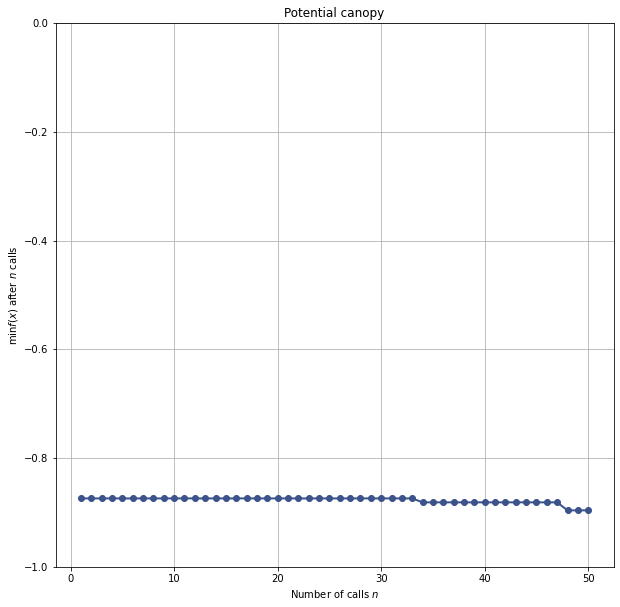

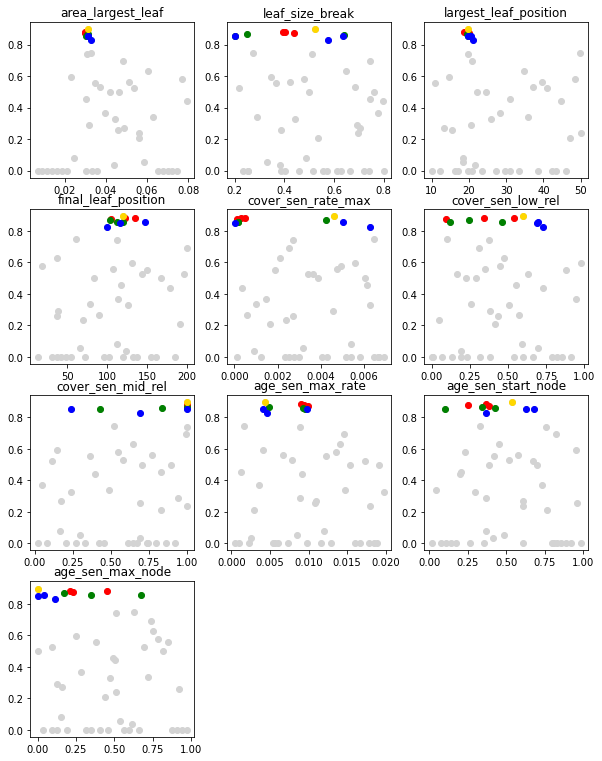

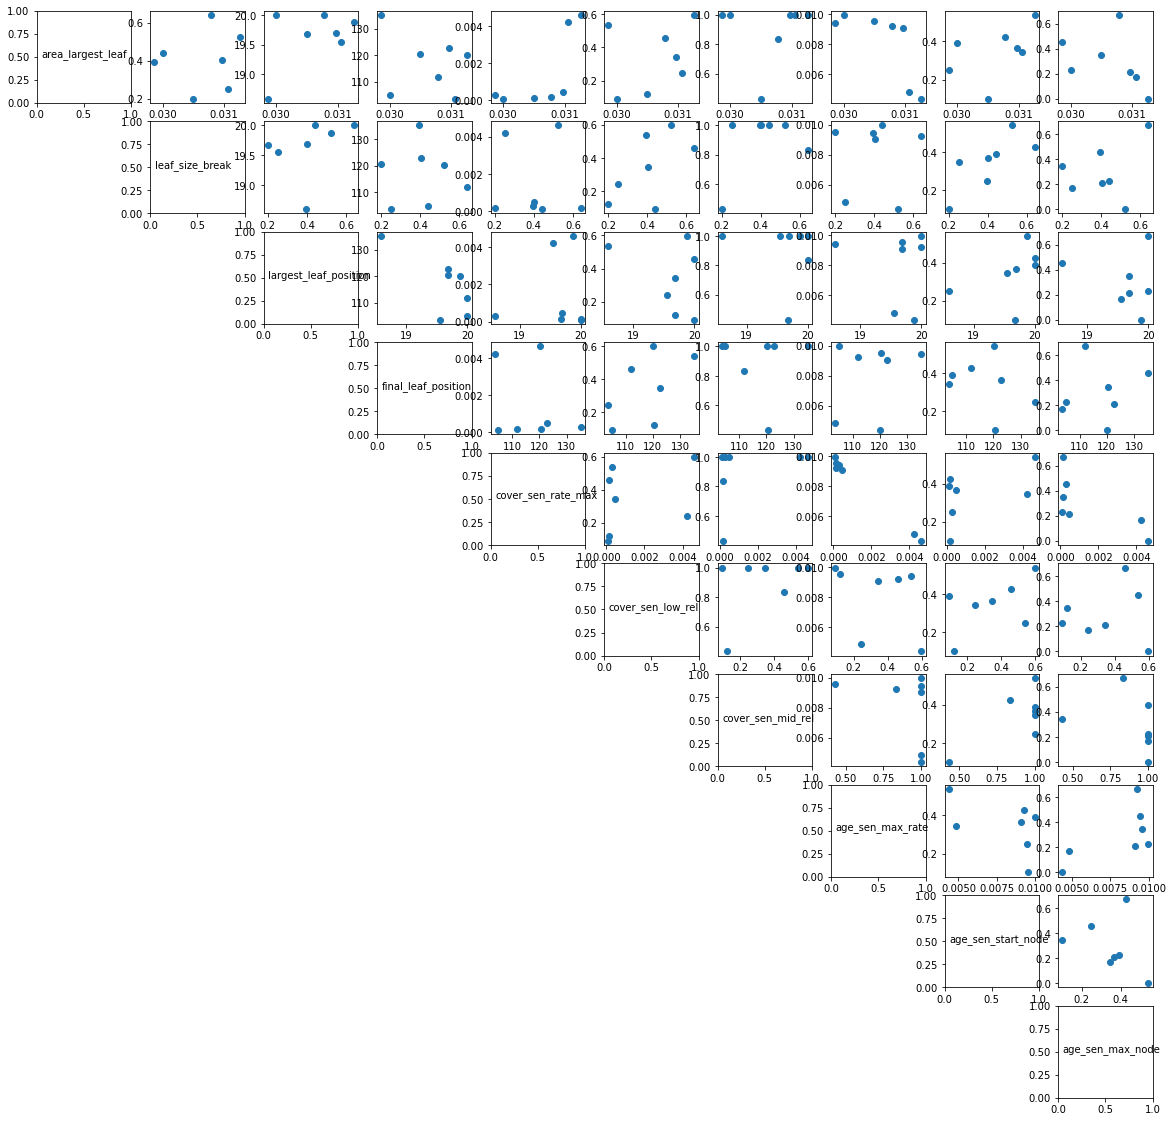

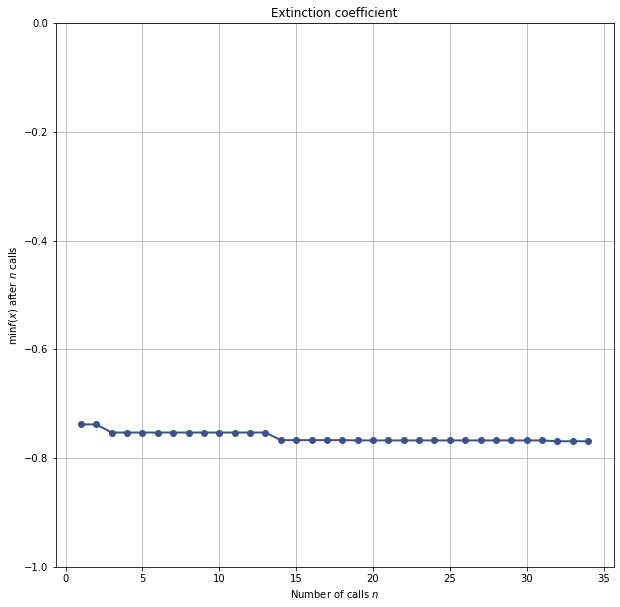

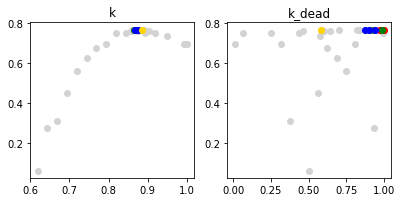

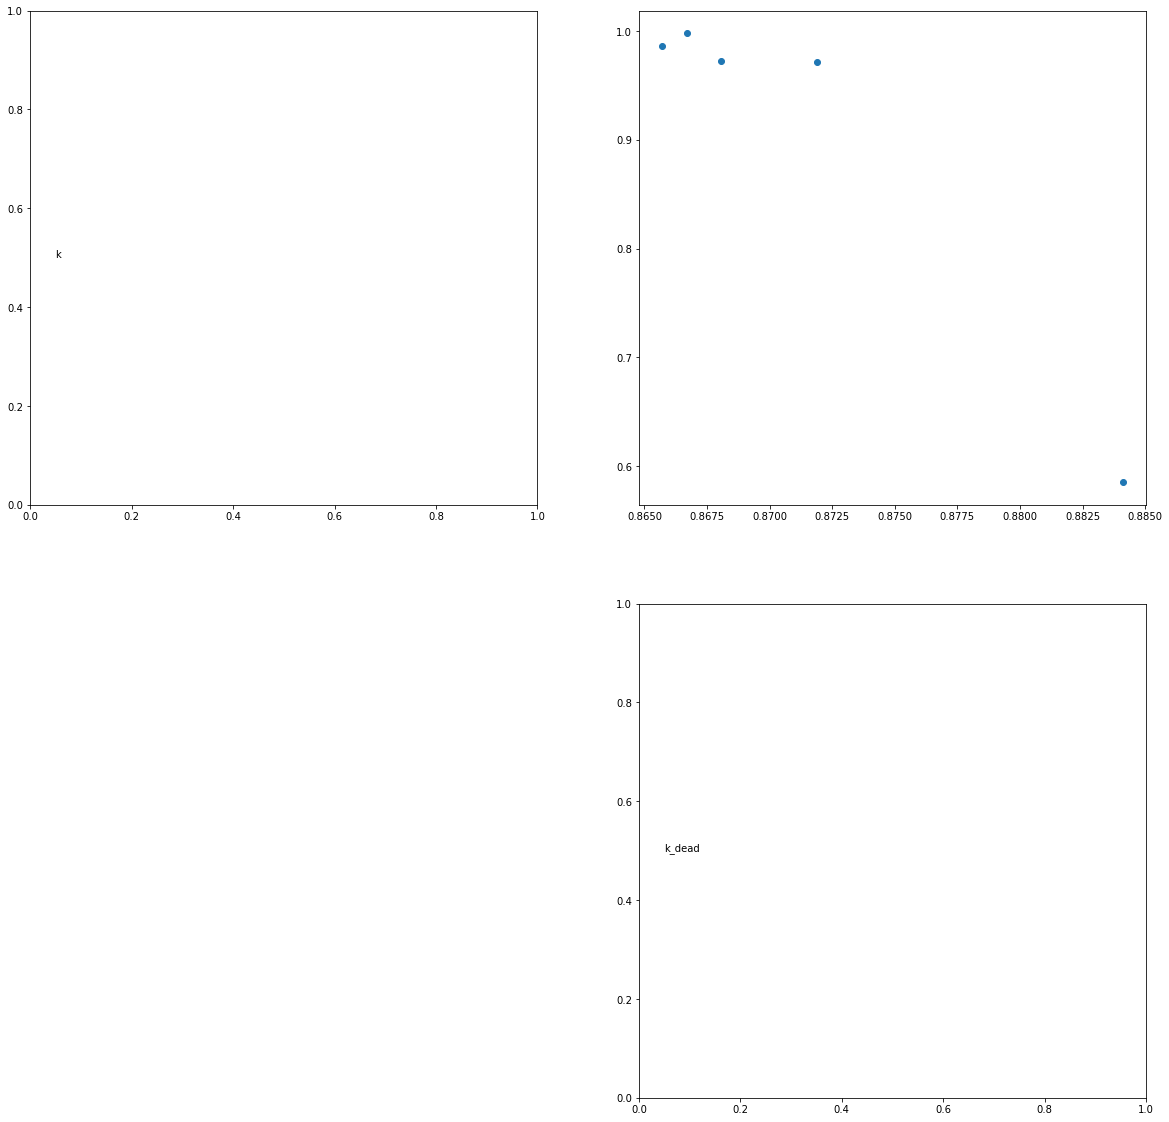

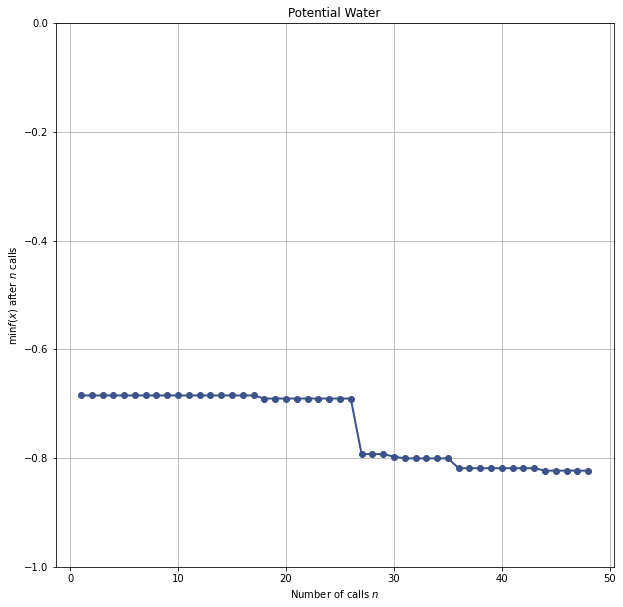

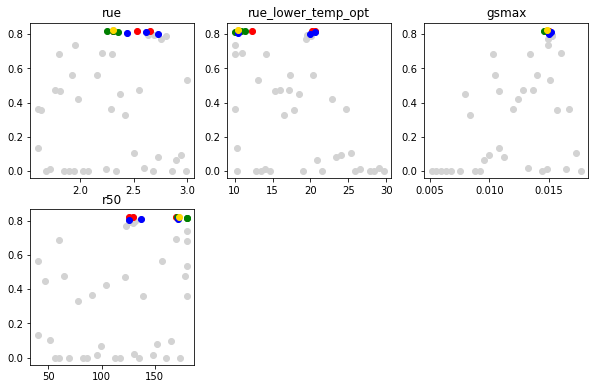

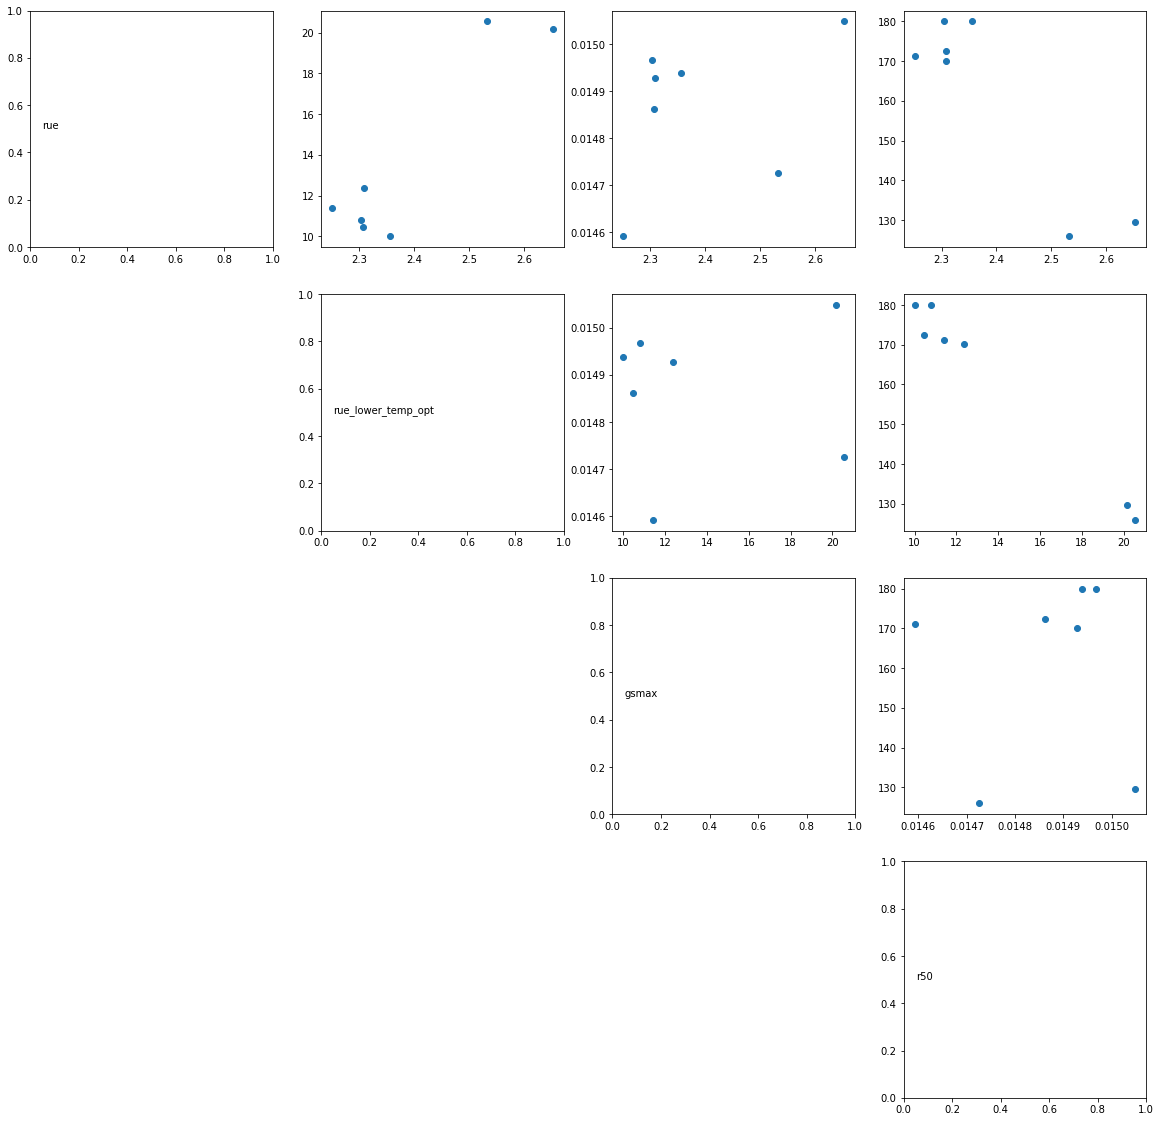

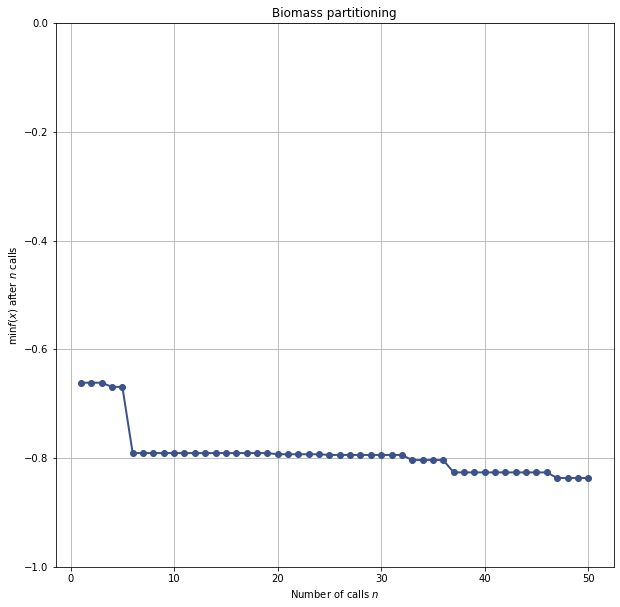

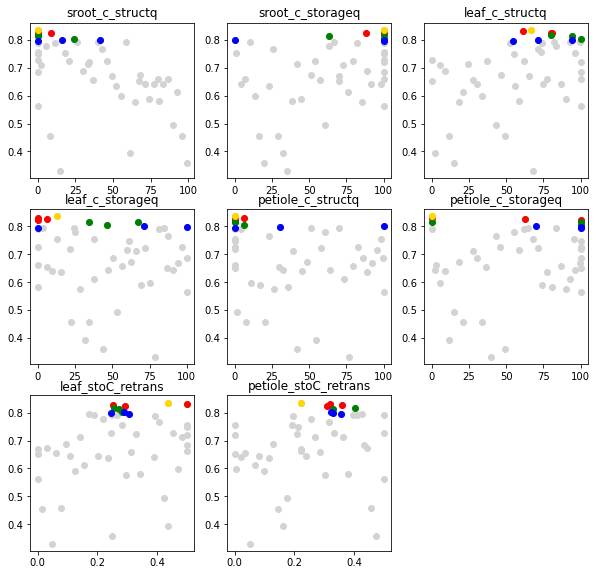

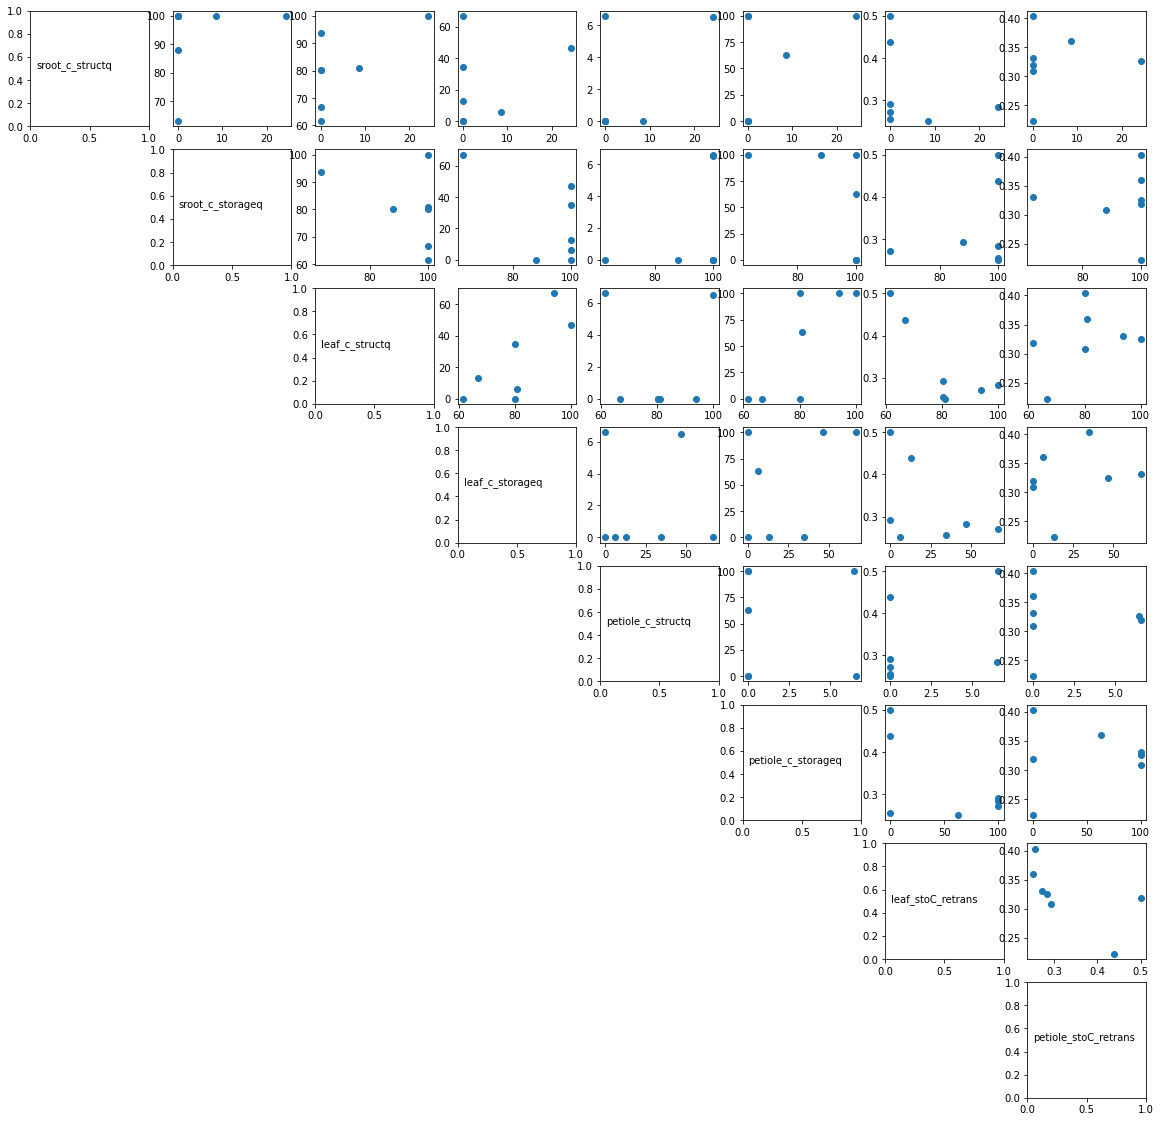

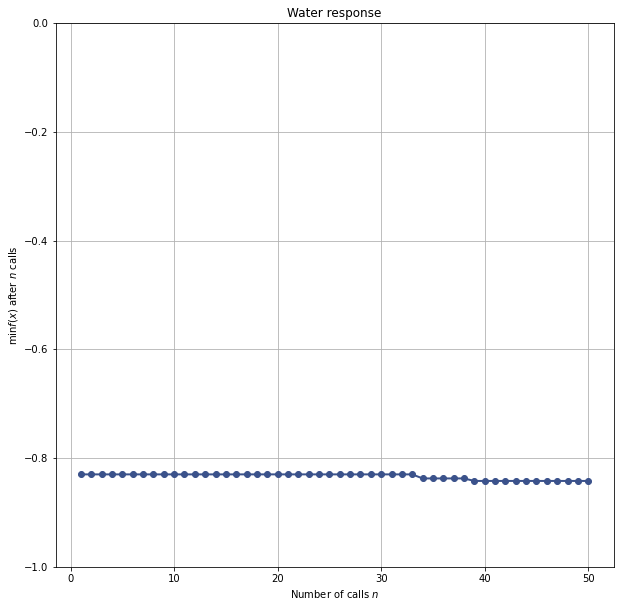

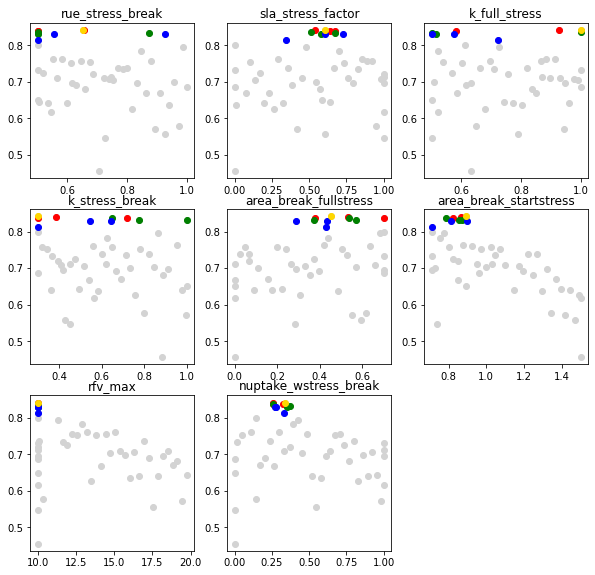

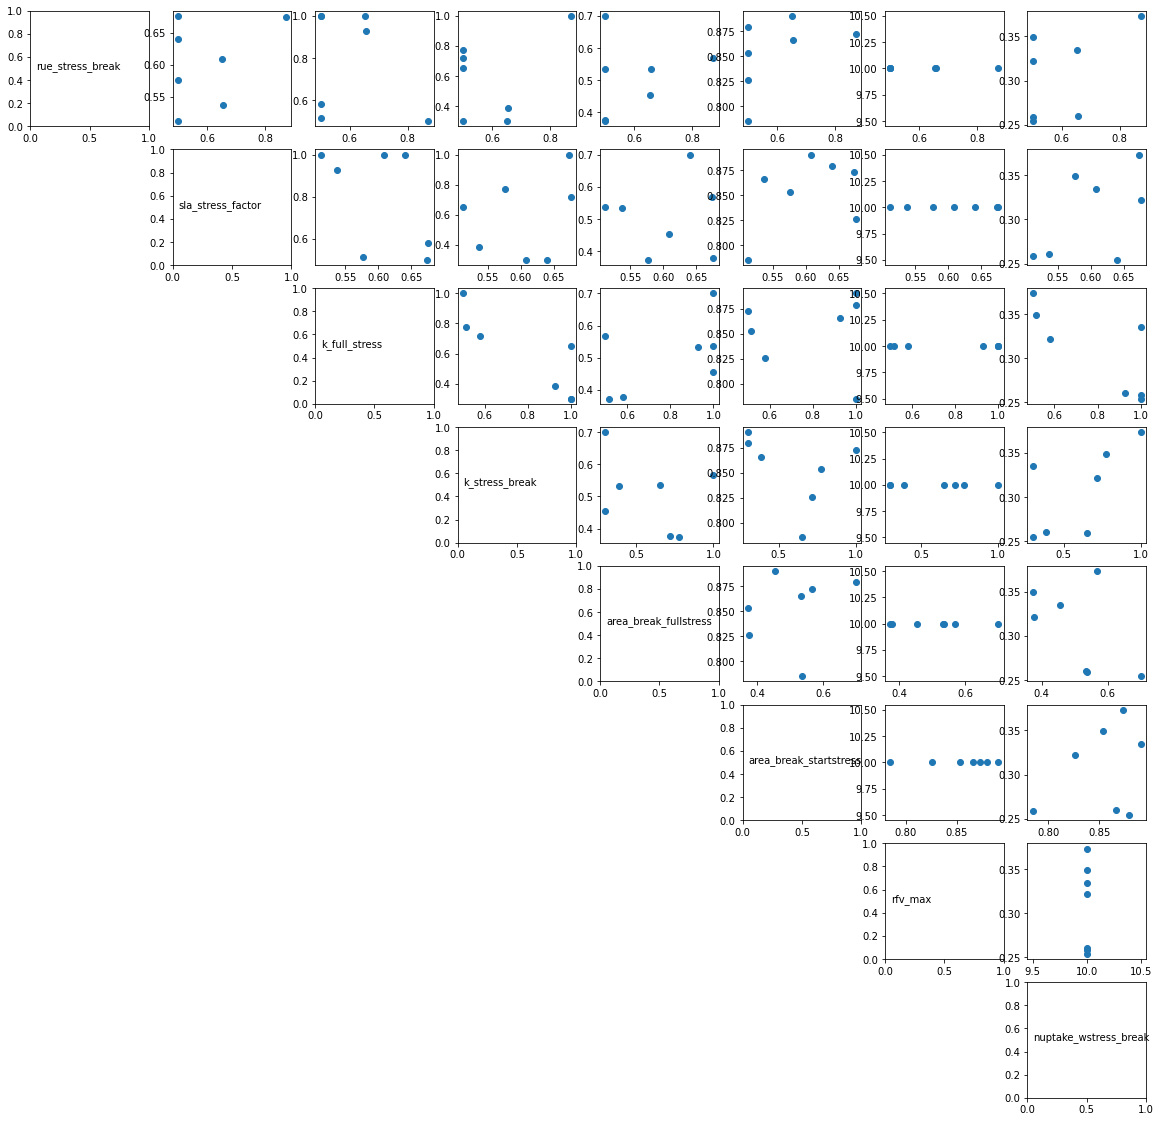

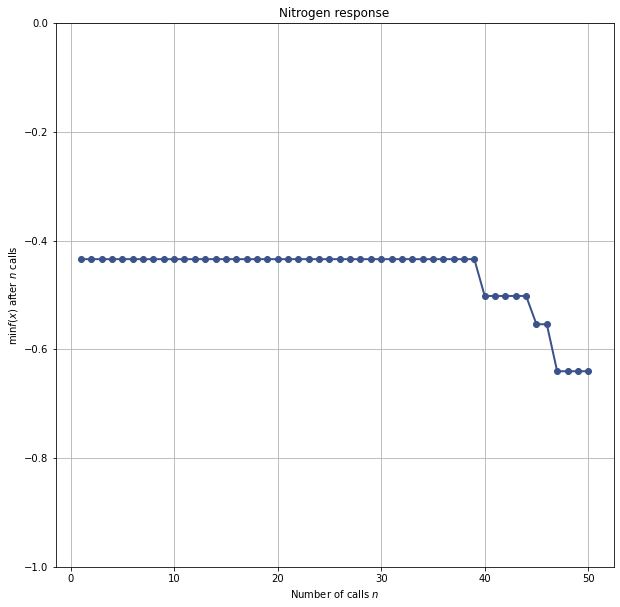

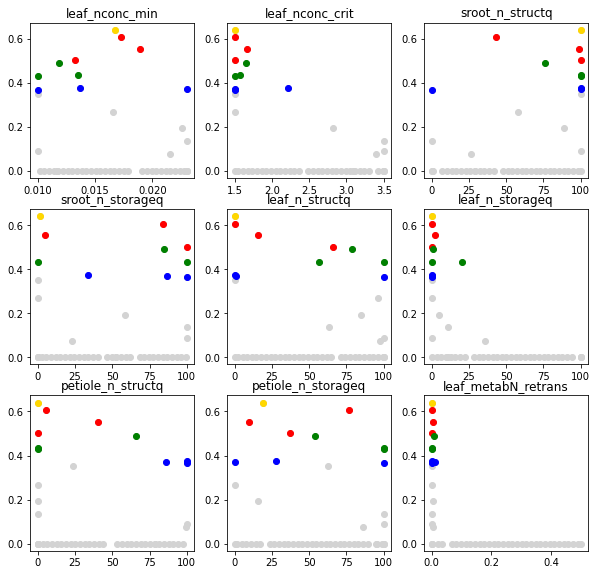

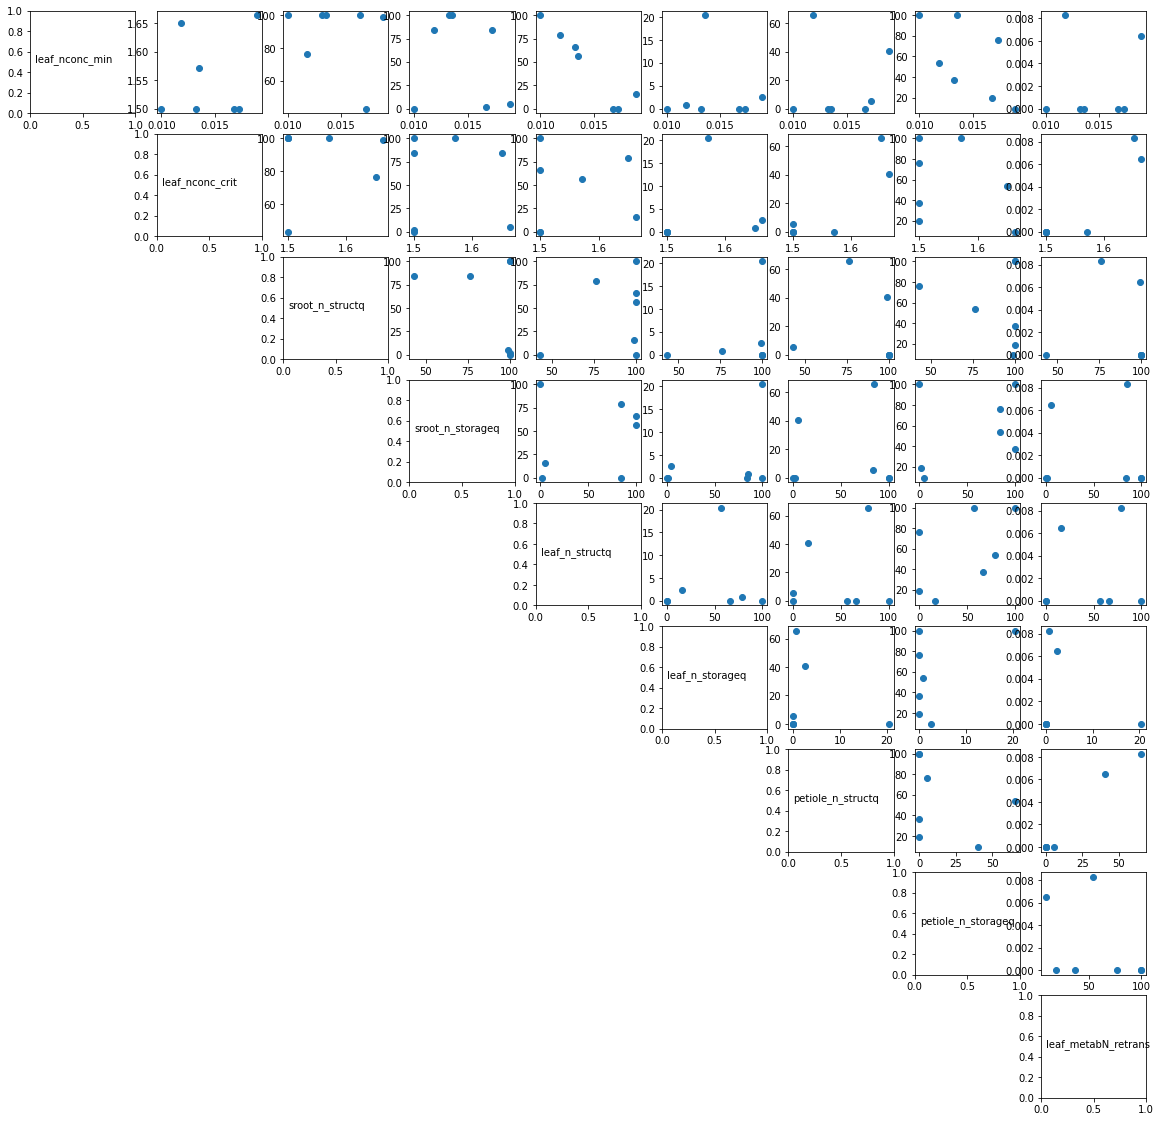

In [16]:
for step in OptimisationSteps:
    ret = load("./"+step+"checkpoint.pkl")
    
    graph = plt.figure(figsize=(10,10))
    plot_convergence(ret);
    plt.ylim(-1,0)
    plt.title(step)

    paramsToOptimise = ParamData.loc[ParamData.loc[:,step] == 'fit',step].index.values.tolist()
    Params = pd.DataFrame(data = ret.x_iters,columns=paramsToOptimise)
    Params.loc[:,"fits"] = ret.func_vals
    Params.sort_values('fits',inplace=True)
    graph = plt.figure(figsize=(10,20))
    pos = 1
    for var in paramsToOptimise:
        ax = graph.add_subplot(6,3,pos)
        plt.plot(Params.loc[:,var],-1*Params.loc[:,'fits'],'o',color='lightgrey')
        plt.plot(Params.loc[:,var].iloc[1:4],-1*Params.loc[:,'fits'].iloc[1:4],'o',color='r')
        plt.plot(Params.loc[:,var].iloc[4:7],-1*Params.loc[:,'fits'].iloc[4:7],'o',color='g')
        plt.plot(Params.loc[:,var].iloc[7:10],-1*Params.loc[:,'fits'].iloc[7:10],'o',color='b')
        plt.plot(ret.x[pos-1],-ret.fun,'o',color='gold')
        plt.title(var)
        pos+=1

    graph = plt.figure(figsize=(20,20))
    done = 0 
    for xvar in paramsToOptimise:
        n = len(paramsToOptimise)
        pos = (done * n) + done + 1
        for yvar in paramsToOptimise[done:]:
            ax = graph.add_subplot(n,n,pos)
            num10 = int(Params.index.size * 0.15)
            top10 = Params.iloc[:num10,:]
            if xvar != yvar:
                plt.plot(top10.loc[:,xvar],top10.loc[:,yvar],'o')
            else:
                plt.text(0.05,0.5,xvar,transform=ax.transAxes)
            pos+=1
        done+=1